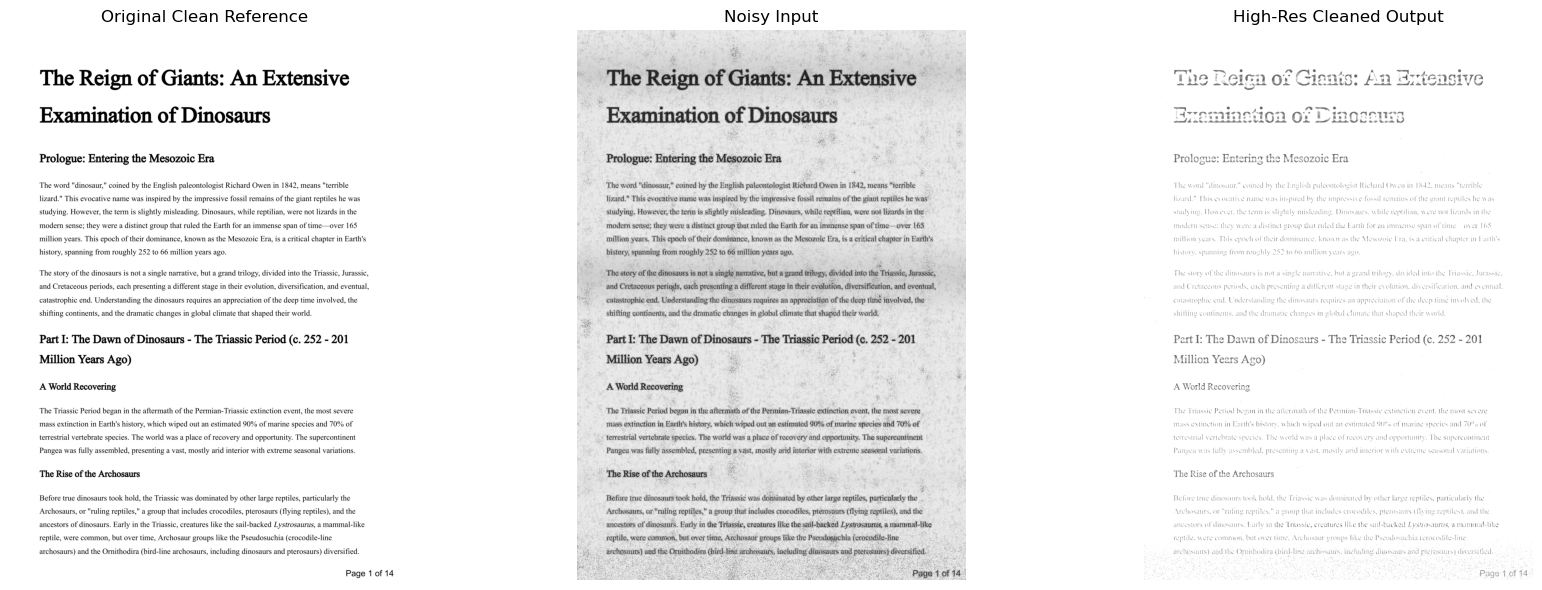

True

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clean_document_highres(image_path, upscale_factor=2):
    # === Step 1. Load in full resolution ===
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # === Step 2. Optional upscale for extra clarity (super-resolution style) ===
    if upscale_factor > 1:
        img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

    # === Step 3. Convert to grayscale ===
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # === Step 4. Gentle denoising while preserving text edges ===
    denoised = cv2.fastNlMeansDenoising(gray, None, h=15, templateWindowSize=7, searchWindowSize=21)

    # === Step 5. Remove uneven illumination (background flattening) ===
    background = cv2.medianBlur(denoised, 51)
    normalized = cv2.divide(denoised, background, scale=255)

    # === Step 6. Enhance contrast subtly ===
    enhanced = cv2.convertScaleAbs(normalized, alpha=1.7, beta=15)

    # === Step 7. Light unsharp masking (crisp letters) ===
    blur = cv2.GaussianBlur(enhanced, (0,0), sigmaX=1.0)
    sharp = cv2.addWeighted(enhanced, 1.8, blur, -0.8, 0)

    # === Step 8. Force background to perfect white ===
    white_bg = np.where(sharp > 235, 255, sharp).astype(np.uint8)

    # === Step 9. Save and return result ===
    cv2.imwrite("document_clean_highres.png", white_bg, [cv2.IMWRITE_PNG_COMPRESSION, 0])

    return white_bg


def show_comparison(original_path, noisy_path):
    original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    noisy = cv2.imread(noisy_path)
    cleaned = clean_document_highres(noisy_path, upscale_factor=2)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Clean Reference")
    axs[1].imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Noisy Input")
    axs[2].imshow(cleaned, cmap='gray')
    axs[2].set_title("High-Res Cleaned Output")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Example Usage ===
show_comparison("sample_1.png", "sample_1_noisy.png")
cv2.imwrite("sample_1_highres_cleaned.png", clean_document_highres("sample_1_noisy.png"))